# Greedy Algorithm for Antenna Placement Optimization

This notebook implements a simplified cost-optimized greedy algorithm for antenna placement on a grid.

## Problem Description

Given:
- A grid with houses that need cellular coverage
- Three antenna types with different costs and coverage radius
- Each house contains **100 users**
- Antennas **cannot** be placed on houses

Goal:
- Cover all houses (100% coverage)
- Minimize total antenna deployment cost
- Use the most cost-efficient antenna placements

In [37]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import List, Tuple, Set, Dict
from enum import Enum

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Constants and Antenna Specifications

We define three antenna types with their properties:
- **Small**: Shortest range, cheapest
- **Medium**: Moderate range and cost
- **Large**: Longest range, most expensive

In [38]:
# Constants
USERS_PER_HOUSE = 100

# Antenna Types
class AntennaType(str, Enum):
    SMALL = "Small"
    MEDIUM = "Medium"
    LARGE = "Large"

# Antenna Specifications
class AntennaSpec:
    def __init__(self, type: AntennaType, radius: int, max_users: int, cost: int):
        self.type = type
        self.radius = radius
        self.max_users = max_users
        self.cost = cost
    
    def __repr__(self):
        return f"{self.type.value}(radius={self.radius}, max_users={self.max_users}, cost=${self.cost})"

# Define antenna specifications
ANTENNA_SPECS = {
    AntennaType.SMALL: AntennaSpec(AntennaType.SMALL, radius=2, max_users=200, cost=1000),
    AntennaType.MEDIUM: AntennaSpec(AntennaType.MEDIUM, radius=4, max_users=500, cost=1500),
    AntennaType.LARGE: AntennaSpec(AntennaType.LARGE, radius=6, max_users=1000, cost=2000),
}

print("Antenna Specifications:")
for spec in ANTENNA_SPECS.values():
    print(f"  {spec}")

Antenna Specifications:
  Small(radius=2, max_users=200, cost=$1000)
  Medium(radius=4, max_users=500, cost=$1500)
  Large(radius=6, max_users=1000, cost=$2000)


## Implement Greedy Algorithm Class

The `GreedyAlgorithm` class implements a simplified cost-optimized approach:
1. Finds the antenna placement that covers the most uncovered houses at the lowest cost per house
2. Continues until all houses are covered (100% coverage)
3. Antennas cannot be placed on houses

In [ ]:
class GreedyAlgorithm:
    """Simplified greedy algorithm for cost-optimized antenna placement."""
    
    def __init__(
        self,
        width: int,
        height: int,
        antenna_specs: Dict[AntennaType, AntennaSpec],
        houses: List[Tuple[int, int]]
    ):
        """
        Initialize the greedy algorithm.
        
        Args:
            width: Grid width
            height: Grid height
            antenna_specs: Dictionary of antenna specifications
            houses: List of house coordinates (each has 100 users)
        """
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.covered_houses: Set[Tuple[int, int]] = set()
        self.placed_antennas: List[Dict] = []
        
        print(f"Initialized: {width}x{height} grid, {len(houses)} houses, {len(houses) * USERS_PER_HOUSE} total users")
    
    def get_covered_houses(self, x: int, y: int, radius: int) -> Set[Tuple[int, int]]:
        """Calculate which houses are covered by an antenna at position (x, y)."""
        covered = set()
        
        for house_x, house_y in self.houses:
            # Euclidean distance
            distance = ((x - house_x) ** 2 + (y - house_y) ** 2) ** 0.5
            if distance <= radius:
                covered.add((house_x, house_y))
        
        return covered
    
    def is_valid_position(self, x: int, y: int) -> bool:
        """Check if a position is valid for antenna placement (not on a house)."""
        return (0 <= x < self.width and 
                0 <= y < self.height and 
                (x, y) not in self.houses)
    
    def calculate_users_served(self) -> int:
        """Calculate total users that can actually be served by all placed antennas."""
        total_served = 0
        
        for antenna in self.placed_antennas:
            # Get houses within this antenna's range
            houses_in_range = self.get_covered_houses(
                antenna['x'], 
                antenna['y'], 
                antenna['radius']
            )
            
            # Count users in those houses
            users_in_range = len(houses_in_range) * USERS_PER_HOUSE
            
            # Antenna can only serve up to its max capacity
            users_served_by_this = min(users_in_range, antenna['max_users'])
            total_served += users_served_by_this
        
        return total_served
    
    def find_best_antenna_placement(self):
        """Find the best antenna placement with lowest cost per new house covered."""
        best_position = None
        best_antenna_type = None
        best_cost_efficiency = float('inf')  # Lower is better
        best_new_houses = set()
        
        # Try all antenna types
        for antenna_type, spec in self.antenna_specs.items():
            # Try all positions on the grid
            for x in range(self.width):
                for y in range(self.height):
                    if not self.is_valid_position(x, y):
                        continue
                    
                    # Calculate coverage
                    covered = self.get_covered_houses(x, y, spec.radius)
                    new_houses = covered - self.covered_houses
                    
                    if len(new_houses) > 0:
                        # Cost efficiency = cost per new house covered
                        cost_efficiency = spec.cost / len(new_houses)
                        
                        if cost_efficiency < best_cost_efficiency:
                            best_cost_efficiency = cost_efficiency
                            best_position = (x, y)
                            best_antenna_type = antenna_type
                            best_new_houses = new_houses
        
        if best_position is None:
            return None
        
        return best_position, best_antenna_type, best_new_houses
    
    def optimize(self) -> Dict:
        """Run the greedy algorithm to minimize cost while covering all houses."""
        print("\\nStarting greedy optimization...")
        
        total_houses = len(self.houses)
        total_users_needed = total_houses * USERS_PER_HOUSE
        iteration = 0
        max_iterations = 1000  # Prevent infinite loops
        
        # Continue until all houses are covered AND we have enough capacity
        while iteration < max_iterations:
            iteration += 1
            
            # Check coverage
            houses_covered_count = len(self.covered_houses)
            
            # Calculate users actually served (considering antenna capacity and range)
            users_served = self.calculate_users_served()
            
            # Stop condition: all houses covered AND enough capacity to serve all users
            all_houses_covered = houses_covered_count >= total_houses
            enough_capacity = users_served >= total_users_needed
            
            if all_houses_covered and enough_capacity:
                break
            
            # Find best antenna placement to cover new houses
            result = self.find_best_antenna_placement()
            
            if result is None:
                # No more positions that cover new houses
                if all_houses_covered:
                    print(f"\\n⚠ Warning: All houses covered but insufficient capacity.")
                    print(f"   Users served: {users_served}/{total_users_needed}")
                    print(f"   This configuration cannot serve all users within antenna capacities.")
                else:
                    print(f"\\n⚠ Warning: Could not cover all houses. {houses_covered_count}/{total_houses} covered.")
                break
            
            position, antenna_type, new_houses = result
            spec = self.antenna_specs[antenna_type]
            
            # Place antenna
            antenna_data = {
                "x": position[0],
                "y": position[1],
                "type": antenna_type,
                "radius": spec.radius,
                "max_users": spec.max_users,
                "cost": spec.cost
            }
            self.placed_antennas.append(antenna_data)
            
            # Update coverage
            self.covered_houses.update(new_houses)
            
            coverage_percent = (len(self.covered_houses) / total_houses * 100)
            users_served = self.calculate_users_served()
            
            print(f"  Iteration {iteration}: Placed {antenna_type.value} at {position}, "
                  f"covered {len(new_houses)} new houses, total coverage: {coverage_percent:.1f}%, "
                  f"users served: {users_served}/{total_users_needed}")
        
        # Calculate final statistics
        total_users = total_houses * USERS_PER_HOUSE
        houses_covered_count = len(self.covered_houses)
        users_in_covered_houses = houses_covered_count * USERS_PER_HOUSE
        
        # Calculate actual users served (considering antenna capacity and range)
        users_served = self.calculate_users_served()
        
        # Total capacity across all antennas
        total_capacity = sum(ant["max_users"] for ant in self.placed_antennas)
        
        user_coverage_percentage = (users_served / total_users * 100) if total_users > 0 else 0
        total_cost = sum(ant["cost"] for ant in self.placed_antennas)
        
        # Capacity utilization based on what's actually being used
        capacity_utilization = (users_served / total_capacity * 100) if total_capacity > 0 else 0
        
        print(f"\\n✓ Optimization complete!")
        print(f"  Antennas placed: {len(self.placed_antennas)}")
        print(f"  Total cost: ${total_cost:,}")
        print(f"  Total capacity: {total_capacity:,} users")
        print(f"  Houses covered: {houses_covered_count}/{total_houses}")
        print(f"  Users in covered houses: {users_in_covered_houses:,}")
        print(f"  Users actually served: {users_served:,}/{total_users:,} ({user_coverage_percentage:.1f}%)")
        print(f"  Capacity utilization: {capacity_utilization:.1f}%")
        
        return {
            "antennas": self.placed_antennas,
            "houses_covered": houses_covered_count,
            "total_houses": total_houses,
            "users_covered": users_served,  # Changed to users_served
            "total_users": total_users,
            "coverage_percentage": user_coverage_percentage,
            "total_capacity": total_capacity,
            "capacity_utilization": capacity_utilization,
            "total_cost": total_cost
        }

print("GreedyAlgorithm class defined successfully!")

GreedyAlgorithm class defined successfully!


## Example: Run Optimization on Sample Grid

Let's create a sample grid with random house placements and run the optimization.

In [40]:
# Create a sample grid
np.random.seed(42)
GRID_WIDTH = 20
GRID_HEIGHT = 15

# Generate random house positions (15% of grid cells)
num_houses = int(GRID_WIDTH * GRID_HEIGHT * 0.15)
houses = []
while len(houses) < num_houses:
    x = np.random.randint(0, GRID_WIDTH)
    y = np.random.randint(0, GRID_HEIGHT)
    if (x, y) not in houses:
        houses.append((x, y))

print(f"Grid size: {GRID_WIDTH}x{GRID_HEIGHT}")
print(f"Number of houses: {len(houses)}")
print(f"Total users: {len(houses) * USERS_PER_HOUSE}")

# Initialize and run the greedy algorithm
algorithm = GreedyAlgorithm(
    width=GRID_WIDTH,
    height=GRID_HEIGHT,
    antenna_specs=ANTENNA_SPECS,
    houses=houses
)

result = algorithm.optimize()

Grid size: 20x15
Number of houses: 45
Total users: 4500
Initialized: 20x15 grid, 45 houses, 4500 total users
\nStarting greedy optimization...
  Iteration 1: Placed Large at (6, 8), covered 21 new houses, total coverage: 46.7%
  Iteration 2: Placed Medium at (17, 11), covered 12 new houses, total coverage: 73.3%
  Iteration 3: Placed Medium at (13, 3), covered 4 new houses, total coverage: 82.2%
  Iteration 4: Placed Small at (0, 13), covered 2 new houses, total coverage: 86.7%
  Iteration 5: Placed Small at (1, 1), covered 2 new houses, total coverage: 91.1%
  Iteration 6: Placed Medium at (8, 11), covered 2 new houses, total coverage: 95.6%
  Iteration 7: Placed Small at (4, 0), covered 1 new houses, total coverage: 97.8%
  Iteration 8: Placed Small at (16, 6), covered 1 new houses, total coverage: 100.0%
  All houses covered, but need more capacity. Adding antenna for capacity...
  All houses covered, but need more capacity. Adding antenna for capacity...
  All houses covered, but n

## Visualize Results

Create a visualization showing:
- Houses (red squares)
- Antennas (colored by type)
- Coverage areas (semi-transparent circles)

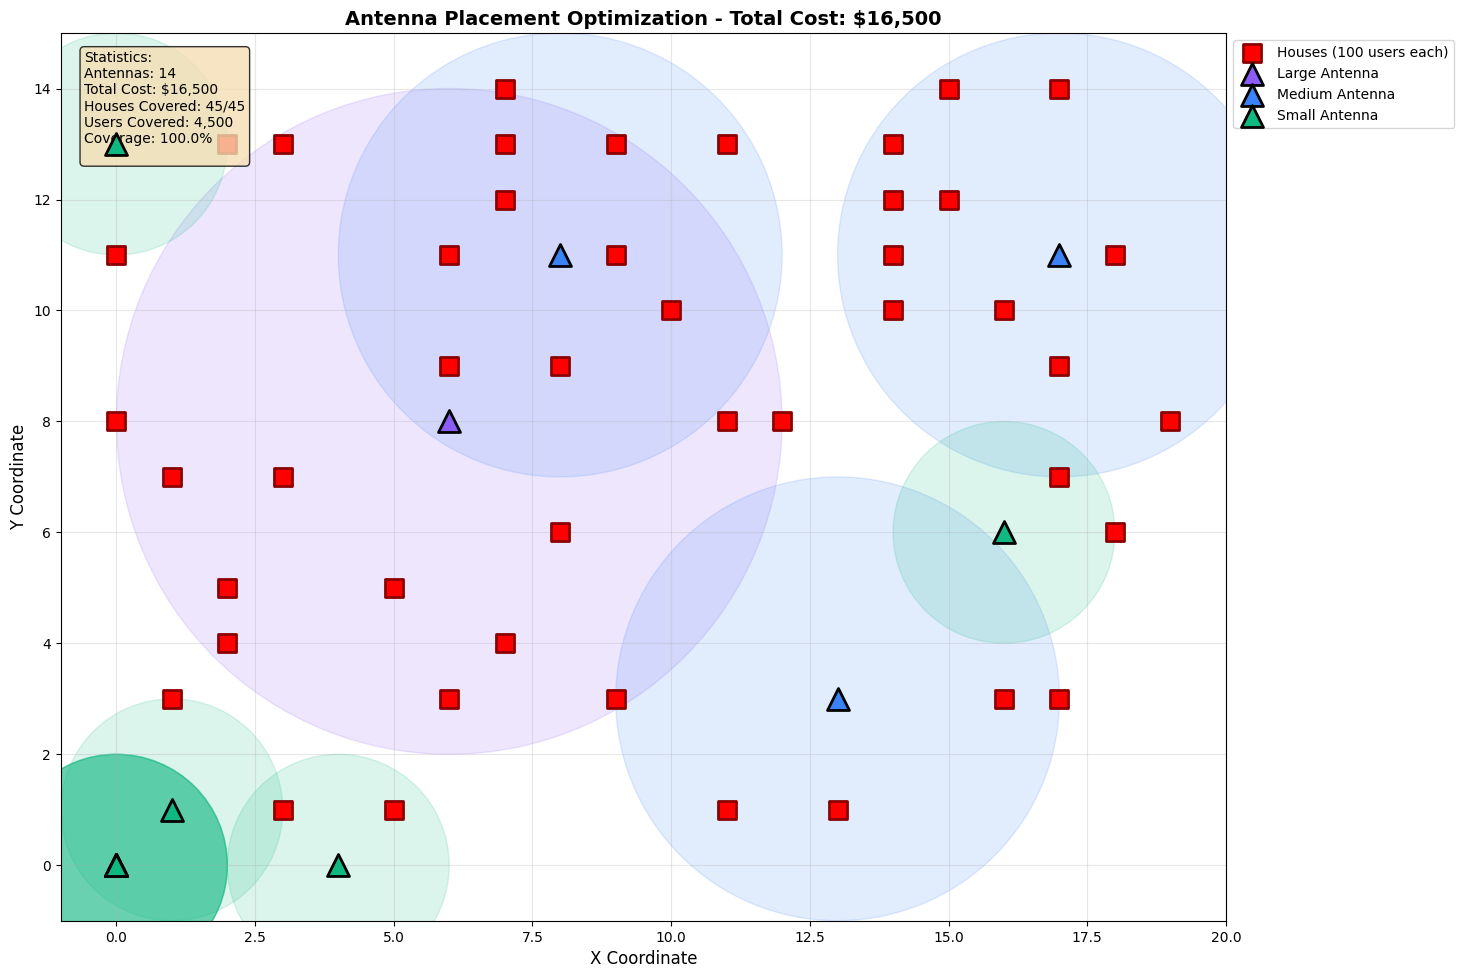

\nAntenna Breakdown by Type:
  Large: 1 antenna(s) - $2,000
  Medium: 3 antenna(s) - $4,500
  Small: 10 antenna(s) - $10,000


In [41]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define colors for each antenna type
antenna_colors = {
    AntennaType.SMALL: '#10B981',   # Green
    AntennaType.MEDIUM: '#3B82F6',  # Blue
    AntennaType.LARGE: '#8B5CF6',   # Purple
}

# Plot coverage circles first (so they're in the background)
for antenna in result['antennas']:
    color = antenna_colors[antenna['type']]
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=color, alpha=0.15, zorder=1)
    ax.add_patch(circle)

# Plot houses
if houses:
    houses_x, houses_y = zip(*houses)
    ax.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
              label='Houses (100 users each)', zorder=3, edgecolors='darkred', linewidth=2)

# Plot antennas
antenna_types = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    if ant_type not in antenna_types:
        antenna_types[ant_type] = {'x': [], 'y': []}
    antenna_types[ant_type]['x'].append(antenna['x'])
    antenna_types[ant_type]['y'].append(antenna['y'])

for ant_type, coords in antenna_types.items():
    color = antenna_colors[ant_type]
    ax.scatter(coords['x'], coords['y'], c=color, s=250, marker='^', 
              label=f'{ant_type.value} Antenna', zorder=4, 
              edgecolors='black', linewidth=2)

# Set grid
ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Antenna Placement Optimization - Total Cost: ${result["total_cost"]:,}', 
            fontsize=14, fontweight='bold')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Add statistics text box
stats_text = f"""Statistics:
Antennas: {len(result['antennas'])}
Total Cost: ${result['total_cost']:,}
Houses Covered: {result['houses_covered']}/{result['total_houses']}
Users Covered: {result['users_covered']:,}
Coverage: {result['coverage_percentage']:.1f}%
"""
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print antenna breakdown
print("\\nAntenna Breakdown by Type:")
antenna_counts = {}
antenna_costs = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    antenna_counts[ant_type] = antenna_counts.get(ant_type, 0) + 1
    antenna_costs[ant_type] = antenna_costs.get(ant_type, 0) + antenna['cost']

for ant_type in sorted(antenna_counts.keys(), key=lambda x: x.value):
    count = antenna_counts[ant_type]
    cost = antenna_costs[ant_type]
    print(f"  {ant_type.value}: {count} antenna(s) - ${cost:,}")

## Test with Different Grid Sizes

Let's test how the algorithm performs on different grid sizes.

In [42]:
# Test with different densities
test_configs = [
    {"width": 15, "height": 15, "density": 0.10, "name": "Low Density (10%)"},
    {"width": 20, "height": 15, "density": 0.15, "name": "Medium Density (15%)"},
    {"width": 25, "height": 20, "density": 0.20, "name": "High Density (20%)"},
]

results_comparison = []

for config in test_configs:
    print("\\n" + "="*70)
    print(f"TEST: {config['name']} - {config['width']}x{config['height']} grid")
    print("="*70)
    
    # Generate houses
    np.random.seed(42)
    num_houses = int(config['width'] * config['height'] * config['density'])
    test_houses = []
    while len(test_houses) < num_houses:
        x = np.random.randint(0, config['width'])
        y = np.random.randint(0, config['height'])
        if (x, y) not in test_houses:
            test_houses.append((x, y))
    
    # Run optimization
    algorithm = GreedyAlgorithm(
        width=config['width'],
        height=config['height'],
        antenna_specs=ANTENNA_SPECS,
        houses=test_houses
    )
    
    result = algorithm.optimize()
    results_comparison.append({
        "name": config['name'],
        "houses": num_houses,
        "users": result['total_users'],
        "antennas": len(result['antennas']),
        "cost": result['total_cost'],
        "cost_per_user": result['total_cost'] / result['total_users'] if result['total_users'] > 0 else 0
    })

# Display comparison
print("\\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"{'Scenario':<25} {'Houses':<10} {'Users':<10} {'Antennas':<12} {'Cost':<12} {'$/User':<10}")
print("-" * 70)
for r in results_comparison:
    print(f"{r['name']:<25} {r['houses']:<10} {r['users']:<10,} {r['antennas']:<12} ${r['cost']:<11,} ${r['cost_per_user']:.2f}")

print("\\nKey Insights:")
print(f"  - Cost per user ranges from ${min(r['cost_per_user'] for r in results_comparison):.2f} to ${max(r['cost_per_user'] for r in results_comparison):.2f}")
print(f"  - Higher density areas may be more cost-efficient per user")

\n======================================================================
TEST: Low Density (10%) - 15x15 grid
Initialized: 15x15 grid, 22 houses, 2200 total users
\nStarting greedy optimization...
  Iteration 1: Placed Large at (8, 6), covered 15 new houses, total coverage: 68.2%
  Iteration 2: Placed Small at (12, 13), covered 4 new houses, total coverage: 86.4%
  Iteration 3: Placed Medium at (0, 7), covered 2 new houses, total coverage: 95.5%
  Iteration 4: Placed Small at (12, 9), covered 1 new houses, total coverage: 100.0%
  All houses covered, but need more capacity. Adding antenna for capacity...
  All houses covered, but need more capacity. Adding antenna for capacity...
\n✓ Optimization complete!
  Antennas placed: 6
  Total cost: $7,500
  Total capacity: 2,300 users
  Houses covered: 22/22
  Users in covered houses: 2,200
  Users actually covered: 2,200/2,200 (100.0%)
  Capacity utilization: 95.7%
\n======================================================================
TEST:

## Algorithm Summary

**Key Features:**
- **Greedy approach**: Selects antenna placement with best cost per house covered
- **Constraint**: Antennas cannot be placed on houses
- **Goal**: 100% coverage with minimum cost
- **Complexity**: O(T × W × H × N) per iteration
  - T = 3 antenna types
  - W × H = grid size
  - N = number of houses
  
**How it works:**
1. For every empty position on the grid
2. Try all 3 antenna types
3. Calculate how many new houses would be covered
4. Select the antenna with lowest cost per new house
5. Repeat until all houses are covered

## Key Takeaways

1. **Simplified Model**: 3 antenna types, 100 users per house, straightforward cost optimization

2. **100% Coverage**: Algorithm guarantees all houses are covered

3. **Cost Efficiency**: Greedy selection based on cost per house covered minimizes total deployment cost

4. **Practical Constraint**: Antennas cannot overlap with houses, simulating real-world placement restrictions

5. **Scalability**: Works efficiently on various grid sizes and house densities

6. **Trade-offs**:
   - Small antennas: Better for isolated houses
   - Medium antennas: Good balance
   - Large antennas: Efficient for clustered houses